In [2]:
#import statements

import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [9]:
#!python -m spacy download en_core_web_sm

In [3]:
NER = spacy.load("en_core_web_sm")

In [4]:
import os
books = []
for items in os.scandir('data'):
    if '.txt' in items.name:
        books.append(items)

In [5]:
books

[<DirEntry 'Fellowship.txt'>,
 <DirEntry 'ROTK.txt'>,
 <DirEntry 'TwoTowers.txt'>]

In [6]:
NER.max_length = 1024531

fellowship = books[0]
fellowship_text = open(fellowship).read()
fellowship_doc = NER(fellowship_text)

In [7]:
#displacy.render(fellowship_doc[0:50000], style='ent', jupyter=True)

In [ ]:
tsv_file = 'Data/lotr_clean.tsv'

csv_table =  pd.read_table(tsv_file, sep='\t')
csv_table.to_csv('Data/lotr_clean.tsv', index=False)
print('Successfully made csv file')

In [9]:
df = pd.read_csv('Data/lotr_clean.csv', usecols=['Character'])
print(df)

     Character
0        Bilbo
1       Elrond
2    Galadriel
3        Bilbo
4        Bilbo
..         ...
677     Elrond
678      Frodo
679  Galadriel
680    Gandalf
681        Sam

[682 rows x 1 columns]


In [10]:
char_list = df.values.tolist()
arr = []
for val in char_list:
    arr.append(val[0])
characters = set(arr)

In [11]:
entity_df = []

for sent in fellowship_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    entity_df.append({'sentence':sent, 'entities': entity_list})
entity_df = pd.DataFrame(entity_df)

In [12]:
entity_df

,sentence,entities
0,"(J., R., R., Tolkien, —, The, Lord, Of, The, R...",[J. R. R. Tolkien]
1,"((, 1/4, ), \n, ------------------------------...","[1/4, RINGS, J. R. R. TOLKIEN, 1, The Two Towe..."
2,"(One, Ring, to, rule, them, all, ,, One, Ring,...","[One, One, Shadows]"
3,"(_, \n\n\n\n\t\t\t, CONTENTS, \n\n , FOREWORD,...",[1]
4,"(Concerning, Hobbits, \n , 2, .)",[2]
...,...,...
13863,"(Then, shouldering, their, burdens, ,, they, s...","[the Emyn Muil, the Land of Shadow]"
13864,"(_, Here, ends, the, first, part, of, the, his...","[first, the War of the Ring]"
13865,"(The, second, part, is, called_THE, TWO, TOWER...","[second, TWO, by_ORTHANC, Saruman, Mordor, the..."
13866,"(The, third, part, tells, of, the, last, defen...","[third, Shadow]"


In [13]:
def filter_entity(ent_list, character):
    return [ent for ent in ent_list
           if ent in list(character)]
filter_entity(["Frodo", "ASDASD", "65"], characters)
    

['Frodo']

In [14]:
entity_df['character_entities'] = entity_df['entities'].apply(lambda x: filter_entity(x, characters))

In [15]:
entity_df_filtered = entity_df[entity_df['character_entities'].map(len) > 0]
entity_df_filtered.head(10)

,sentence,entities,character_entities
89,"(It, is, an, essential, part, of, the, plot, ,...",[Saruman],[Saruman]
93,"(I, never, liked, the, looks, of, the, Young, ...","[Young, Old, Sandyman]",[Sandyman]
102,"(This, book, is, largely, concerned, with, Hob...",[Hobbits],[Hobbits]
105,"(That, story, was, derived, from, the, earlier...","[the Red Book, Bilbo, Hobbit]",[Bilbo]
131,"(Yet, it, is, clear, that, Hobbits, had, ,, in...","[Hobbits, many long years]",[Hobbits]
133,"(But, in, the, days, of, Bilbo, ,, and, of, Fr...","[the days, Bilbo]",[Bilbo]
135,"(Of, their, original, home, the, Hobbits, in, ...",[Bilbo],[Bilbo]
138,"(It, is, clear, ,, nonetheless, ,, from, these...",[Hobbits],[Hobbits]
142,"(Before, the, crossing, of, the, mountains, th...","[Hobbits, three, Fallohides]",[Hobbits]
153,"(They, were, more, friendly, with, Elves, than...",[Hobbits],[Hobbits]


In [18]:
window_size = 5
relationships = []

for i in range(entity_df_filtered.index[-1]):
    end_i = min(i+5, entity_df_filtered.index[-1])
    char_list = sum((entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [19]:
relationship_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Saruman,Sandyman
1,Saruman,Sandyman
2,Hobbits,Bilbo
3,Hobbits,Bilbo
4,Hobbits,Bilbo
5,Hobbits,Bilbo
6,Hobbits,Bilbo
7,Hobbits,Bilbo
8,Hobbits,Bilbo
9,Bilbo,Hobbits


In [20]:
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Sandyman,Saruman
1,Sandyman,Saruman
2,Bilbo,Hobbits
3,Bilbo,Hobbits
4,Bilbo,Hobbits
5,Bilbo,Hobbits
6,Bilbo,Hobbits
7,Bilbo,Hobbits
8,Bilbo,Hobbits
9,Bilbo,Hobbits


In [21]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [22]:
relationship_df.head(10)

,source,target,value
0,Sandyman,Saruman,2
1,Bilbo,Hobbits,28
2,Bilbo,Gandalf,248
3,Bilbo,Frodo,552
4,Celeborn,Elrond,5
5,Celeborn,Galadriel,38
6,Bilbo,Galadriel,4
7,Bilbo,Gaffer,22
8,Frodo,Sandyman,3
9,Gaffer,Sandyman,11


In [23]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

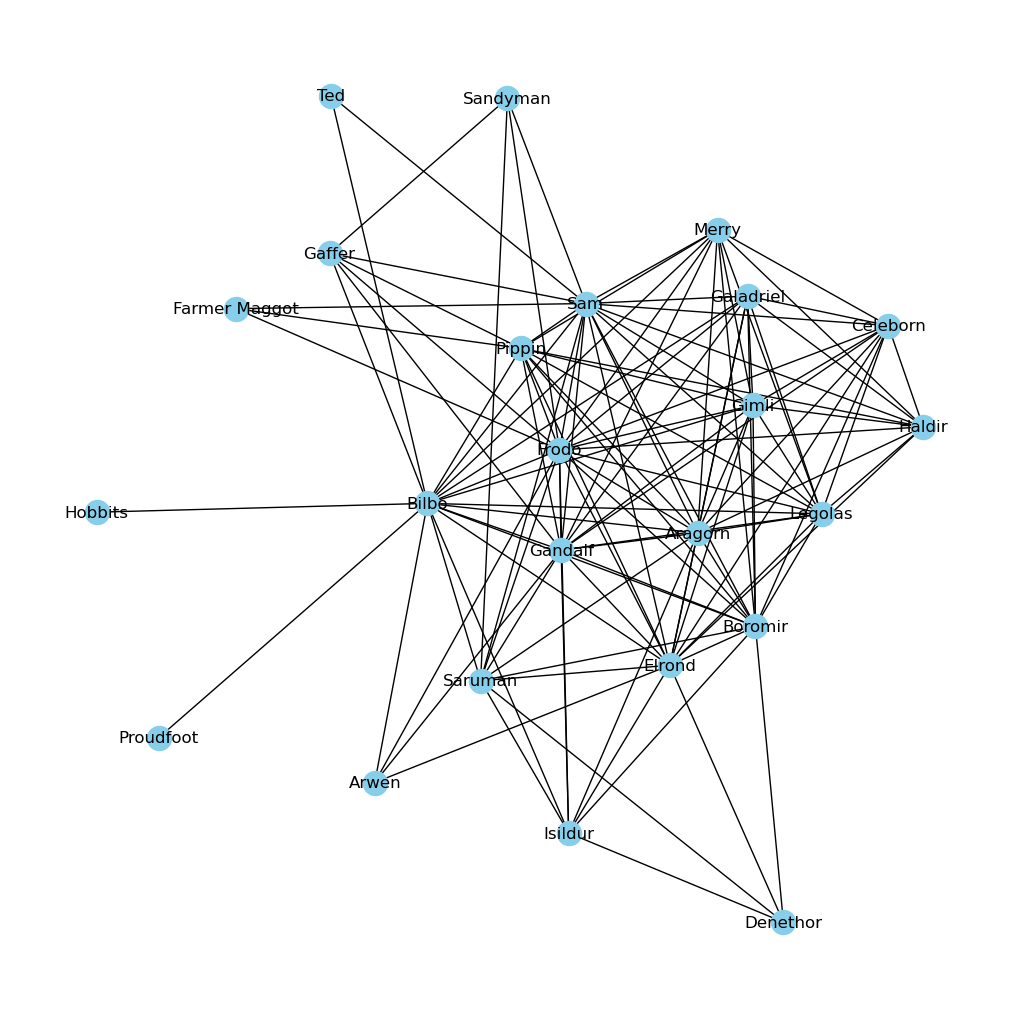

In [24]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [28]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("LOTR.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [31]:
degree_dict = dict(G.degree)

<AxesSubplot:>

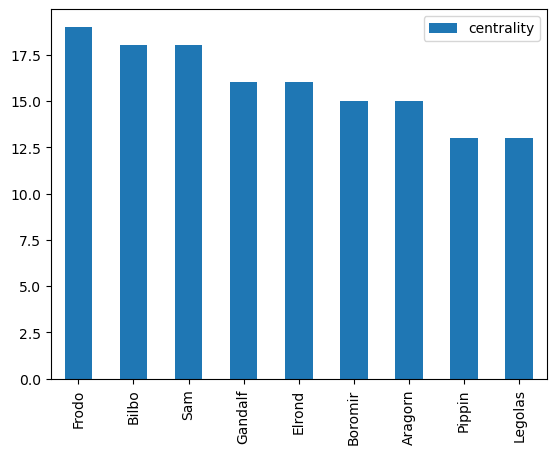

In [32]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

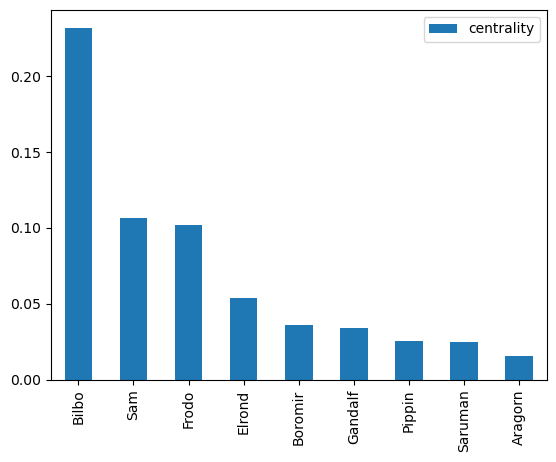

In [33]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

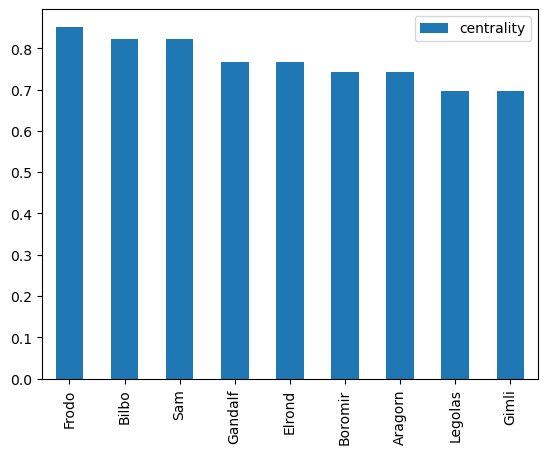

In [34]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [35]:
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')